# Ablation experiment of inferred information with XGBoost (logkcat/KM)

In [1]:
import pandas as pd
import os
current_dir = os.getcwd()
df_input = pd.read_pickle(f'{current_dir}/../data_process/dataset/df_all_log_transformed.pkl')
df_input.head()

,ec,organism,uniprot,substrate,smiles,sequence,type,ph,t,esm2,...,unirep,prott5,prost5,molebert,transsmiles,logkm,logkcat,logkcatkm,logp,mw
0,3.5.5.1,Saccharolobus solfataricus,P95896,trichloroacetonitrile,C(#N)C(Cl)(Cl)Cl,MGIKLPTLEDLREISKQFNLDLEDEELKSFLQLLKLQLESYERLDS...,wild,7.4,70.0,"[0.07309095, -0.085310504, 0.03223636, -0.0094...",...,"[0.004618997, 0.04178079, 0.039039593, -0.0533...","[0.0620778725, 0.0053198822, 0.026737025, -0.0...","[0.0229359791, -0.0089250933, -0.0310355425000...","[-0.0235576797, -0.1898318082, -0.005378013, 0...","[-0.1102231815, -0.2566757202, 0.2837018669, 0...",-21.416413,-4.605170,NaN,1.88018,144.388
1,1.21.99.4,Homo sapiens,,L-thyroxine,C1=C(C=C(C(=C1I)OC2=CC(=C(C(=C2)I)O)I)I)CC(C(=...,MGLPQPGLWLKRLWVLLEVAVHVVVGKVLLILFPDRVKRNILAMGE...,mutant,7.5,37.0,"[0.054237492, -0.04574185, 0.008709021, 0.0387...",...,"[0.009288959, 0.11994403, 0.08886064, -0.00835...","[0.0137849757, 0.0193469338, 0.0360138603, 0.0...","[-0.0300230943, -0.0246387329, -0.0323411487, ...","[0.11776212600000001, 0.24018001560000002, -0....","[-0.049280483300000004, -0.2168657631, 0.30448...",-20.192638,NaN,NaN,4.55730,776.872
2,1.21.99.4,Homo sapiens,,L-thyroxine,C1=C(C=C(C(=C1I)OC2=CC(=C(C(=C2)I)O)I)I)CC(C(=...,MGLPQPGLWLKRLWVLLEVAVHVVVGKVLLILFPDRVKRNILAMGE...,wild,7.5,37.0,"[0.054237492, -0.04574185, 0.008709021, 0.0387...",...,"[0.009288959, 0.11994403, 0.08886064, -0.00835...","[0.0137849757, 0.0193469338, 0.0360138603, 0.0...","[-0.0300230943, -0.0246387329, -0.0323411487, ...","[0.11776212600000001, 0.24018001560000002, -0....","[-0.049280483300000004, -0.2168657631, 0.30448...",-19.658555,NaN,NaN,4.55730,776.872
3,3.5.5.1,Saccharolobus solfataricus,P95896,Cinnamonitrile,C1=CC=C(C=C1)C=CC#N,MGIKLPTLEDLREISKQFNLDLEDEELKSFLQLLKLQLESYERLDS...,mutant,7.4,70.0,"[0.07308519, -0.08452837, 0.029972142, -0.0119...",...,"[0.0046866684999999995, 0.04164683, 0.03819374...","[0.0622685216, 0.0037881299, 0.027366610200000...","[0.022653413900000002, -0.008009411400000001, ...","[0.1382588446, -0.2295262814, -0.0154548008, 0...","[-0.07580477000000001, -0.26762363310000004, 0...",-18.451140,-4.135167,NaN,2.22338,129.162
4,3.5.5.1,Saccharolobus solfataricus,P95896,Malononitrile,C(C#N)C#N,MGIKLPTLEDLREISKQFNLDLEDEELKSFLQLLKLQLESYERLDS...,wild,7.4,70.0,"[0.07309095, -0.085310504, 0.03223636, -0.0094...",...,"[0.004618997, 0.04178079, 0.039039593, -0.0533...","[0.0620778725, 0.0053198822, 0.026737025, -0.0...","[0.0229359791, -0.0089250933, -0.0310355425000...","[0.4168405533, -0.2187459022, -0.1292698383, 0...","[-0.0909005329, -0.2873343229, 0.2866819799, 0...",-16.821293,-1.966113,NaN,0.42366,66.063


In [2]:
import os.path
import json
import pandas as pd
import xgboost
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from hyperopt import fmin, tpe, hp, Trials, space_eval
from copy import deepcopy


def return_scores(y_true, y_pred):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc = pearsonr(y_true, y_pred)[0]

    return rmse, mae, r2, pcc

def return_xgb_x_y(df_filtered):
    y = df_filtered[label_name].values
    mask = ~np.isnan(y)

    protein_data = np.array(df_filtered[protein_column].tolist())
    substrate_data = np.array(df_filtered[substrate_column].tolist())
    x = np.hstack((protein_data, substrate_data))

    return x[mask], y[mask]

def search_xgb(params):
    print(params)
    temp_params = deepcopy(params)
    temp_params.update({"device": "cuda", "eval_metric": ["rmse"], "sampling_method": "gradient_based"})
    num_rounds = temp_params.pop('num_rounds')

    val_scores_list = []
    for train_index, val_index in kf.split(df_train_val):
        df_train = df_train_val.iloc[train_index]
        df_val = df_train_val.iloc[val_index]

        train_x, train_y = return_xgb_x_y(df_train)
        val_x, val_y = return_xgb_x_y(df_val)

        # DMatrix
        m_train = xgboost.DMatrix(train_x, label=train_y)
        m_val = xgboost.DMatrix(val_x, label=val_y)
        eval_list = [(m_train, 'train'), (m_val, 'val')]

        # train
        model = xgboost.train(temp_params, m_train, num_rounds, evals=eval_list, verbose_eval=False, early_stopping_rounds=60)

        # val
        val_predicted = model.predict(xgboost.DMatrix(val_x))
        val_scores = return_scores(val_y, val_predicted)
        val_scores_list.append(val_scores)

    val_scores_mean = np.mean(val_scores_list, axis=0)
    print(f"[Val_mean] rmse {val_scores_mean[0]:.3f} mae {val_scores_mean[1]:.3f} r2 {val_scores_mean[2]:.3f} pcc {val_scores_mean[3]:.3f}")

    return val_scores_mean[0]

def search_best_param(max_evals):
    space = {
        "learning_rate": hp.uniform("learning_rate", 0.02, 0.1),
        "max_depth": hp.randint("max_depth", 6, 9),
        "reg_lambda": hp.uniform("reg_lambda", 0, 3),
        "reg_alpha": hp.uniform("reg_alpha", 0, 3),
        "max_delta_step": hp.uniform("max_delta_step", 0, 4),
        "min_child_weight": hp.uniform("min_child_weight", 10, 15),
        "num_rounds": hp.randint("num_rounds", 1500, 3000),
        "subsample": hp.uniform("subsample", 0, 1),
        "eta": hp.uniform("eta", 0.01, 0.2),
    }

    trials = Trials()
    print(f'[Info] Starting parameter search...')
    best_params = fmin(fn=search_xgb, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['num_rounds'] = int(best_params['num_rounds'])

    best_params = space_eval(space, best_params)

    # to json
    with open(params_json_path, 'w') as json_file:
        json.dump(best_params, json_file)

    return best_params


# main
protein_columns = ['unirep', 'esm2', 'esmc', 'prott5', 'prost5']
substrate_columns = ['molebert', 'transsmiles']
label_name = 'logkcatkm'
random_state = 66

df_train_val, df_test = train_test_split(df_input, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# save results
results = []
cv_results = []

for protein_column in protein_columns:
    for substrate_column in substrate_columns:
        val_scores_list = []
        test_scores_list = []
        print(f"{protein_column} + {substrate_column}: ")

        # search best params
        params_json_path = f'model_dict/{protein_column}_{substrate_column}.json'
        if os.path.exists(params_json_path):
            with open(params_json_path) as json_file:
                params = json.load(json_file)
        else:
            params = search_best_param(60)

        # train
        _params = deepcopy(params)
        _params.update({"device": "cuda", "eval_metric": ["rmse"], "sampling_method": "gradient_based"})
        num_rounds = _params.pop('num_rounds')
        for fold, (train_index, val_index) in enumerate(kf.split(df_train_val), start=1):
            print(f"Fold: {fold}/5")
            df_train = df_train_val.iloc[train_index]
            df_val = df_train_val.iloc[val_index]

            train_x, train_y = return_xgb_x_y(df_train)
            val_x, val_y = return_xgb_x_y(df_val)
            test_x, test_y = return_xgb_x_y(df_test)

            # DMatrix
            m_train = xgboost.DMatrix(train_x, label=train_y)
            m_val = xgboost.DMatrix(val_x, label=val_y)
            eval_list = [(m_train, 'train'), (m_val, 'val')]

            # train
            model = xgboost.train(_params, m_train, num_rounds, evals=eval_list, verbose_eval=1000, early_stopping_rounds=60)

            # val
            val_predicted = model.predict(xgboost.DMatrix(val_x))
            val_scores = return_scores(val_y, val_predicted)
            val_scores_list.append(val_scores)

            # test
            test_predicted = model.predict(xgboost.DMatrix(test_x))
            test_scores = return_scores(test_y, test_predicted)
            test_scores_list.append(test_scores)

            # fold
            cv_results.append([
                protein_column, substrate_column, fold,
                val_scores[0], val_scores[1], val_scores[2], val_scores[3],
                test_scores[0], test_scores[1], test_scores[2], test_scores[3]
            ])

        # mean
        val_scores_mean = np.mean(val_scores_list, axis=0)
        test_scores_mean = np.mean(test_scores_list, axis=0)

        print(f"[Val] rmse {val_scores_mean[0]:.4f} mae {val_scores_mean[1]:.4f} r2 {val_scores_mean[2]:.4f} pcc {val_scores_mean[3]:.4f} "
              f"[Test] rmse {test_scores_mean[0]:.4f} mae {test_scores_mean[1]:.4f} r2 {test_scores_mean[2]:.4f} pcc {test_scores_mean[3]:.4f}\n")

        # 存入均值结果
        results.append([
            protein_column, substrate_column,
            val_scores_mean[0], val_scores_mean[1], val_scores_mean[2], val_scores_mean[3],
            test_scores_mean[0], test_scores_mean[1], test_scores_mean[2], test_scores_mean[3]
        ])

# save
df_results = pd.DataFrame(results, columns=["Protein", "Substrate",
    "Val_RMSE", "Val_MAE", "Val_R2", "Val_PCC",
    "Test_RMSE", "Test_MAE", "Test_R2", "Test_PCC"])
df_results.to_excel(f"{current_dir}/results.xlsx", index=False)

# save cvs
df_cv_results = pd.DataFrame(cv_results, columns=[
    "Protein", "Substrate", "Fold",
    "Val_RMSE", "Val_MAE", "Val_R2", "Val_PCC",
    "Test_RMSE", "Test_MAE", "Test_R2", "Test_PCC"])
df_cv_results.to_excel(f"{current_dir}/cv_results.xlsx", index=False)
print("Results saved to results.xlsx and cv_results.xlsx")

unirep + molebert: 
[Info] Starting parameter search...
{'eta': 0.12105867295453053, 'learning_rate': 0.04282491452692577, 'max_delta_step': 0.43763635835355164, 'max_depth': 6, 'min_child_weight': 14.46017500259056, 'num_rounds': 1583, 'reg_alpha': 1.2894937501242796, 'reg_lambda': 0.001328688966460323, 'subsample': 0.9297308323736826}
[Val_mean] rmse 2.785 mae 2.069 r2 0.551 pcc 0.743
{'eta': 0.02537076271948584, 'learning_rate': 0.08123474832344202, 'max_delta_step': 3.012374376692057, 'max_depth': 6, 'min_child_weight': 12.856317732708856, 'num_rounds': 2014, 'reg_alpha': 0.2554921601969098, 'reg_lambda': 1.9922886361126118, 'subsample': 0.18949288789701335}
[Val_mean] rmse 2.798 mae 2.068 r2 0.546 pcc 0.741
{'eta': 0.18709272125572166, 'learning_rate': 0.022998838598961572, 'max_delta_step': 1.3985325268476556, 'max_depth': 7, 'min_child_weight': 14.926883436095109, 'num_rounds': 2786, 'reg_alpha': 2.2053175605547395, 'reg_lambda': 0.067897147726238, 'subsample': 0.932339841320842

C:\Users\ching\AppData\Local\Temp\ipykernel_19788\666786242.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(r2_values, labels=combination_names, patch_artist=True)


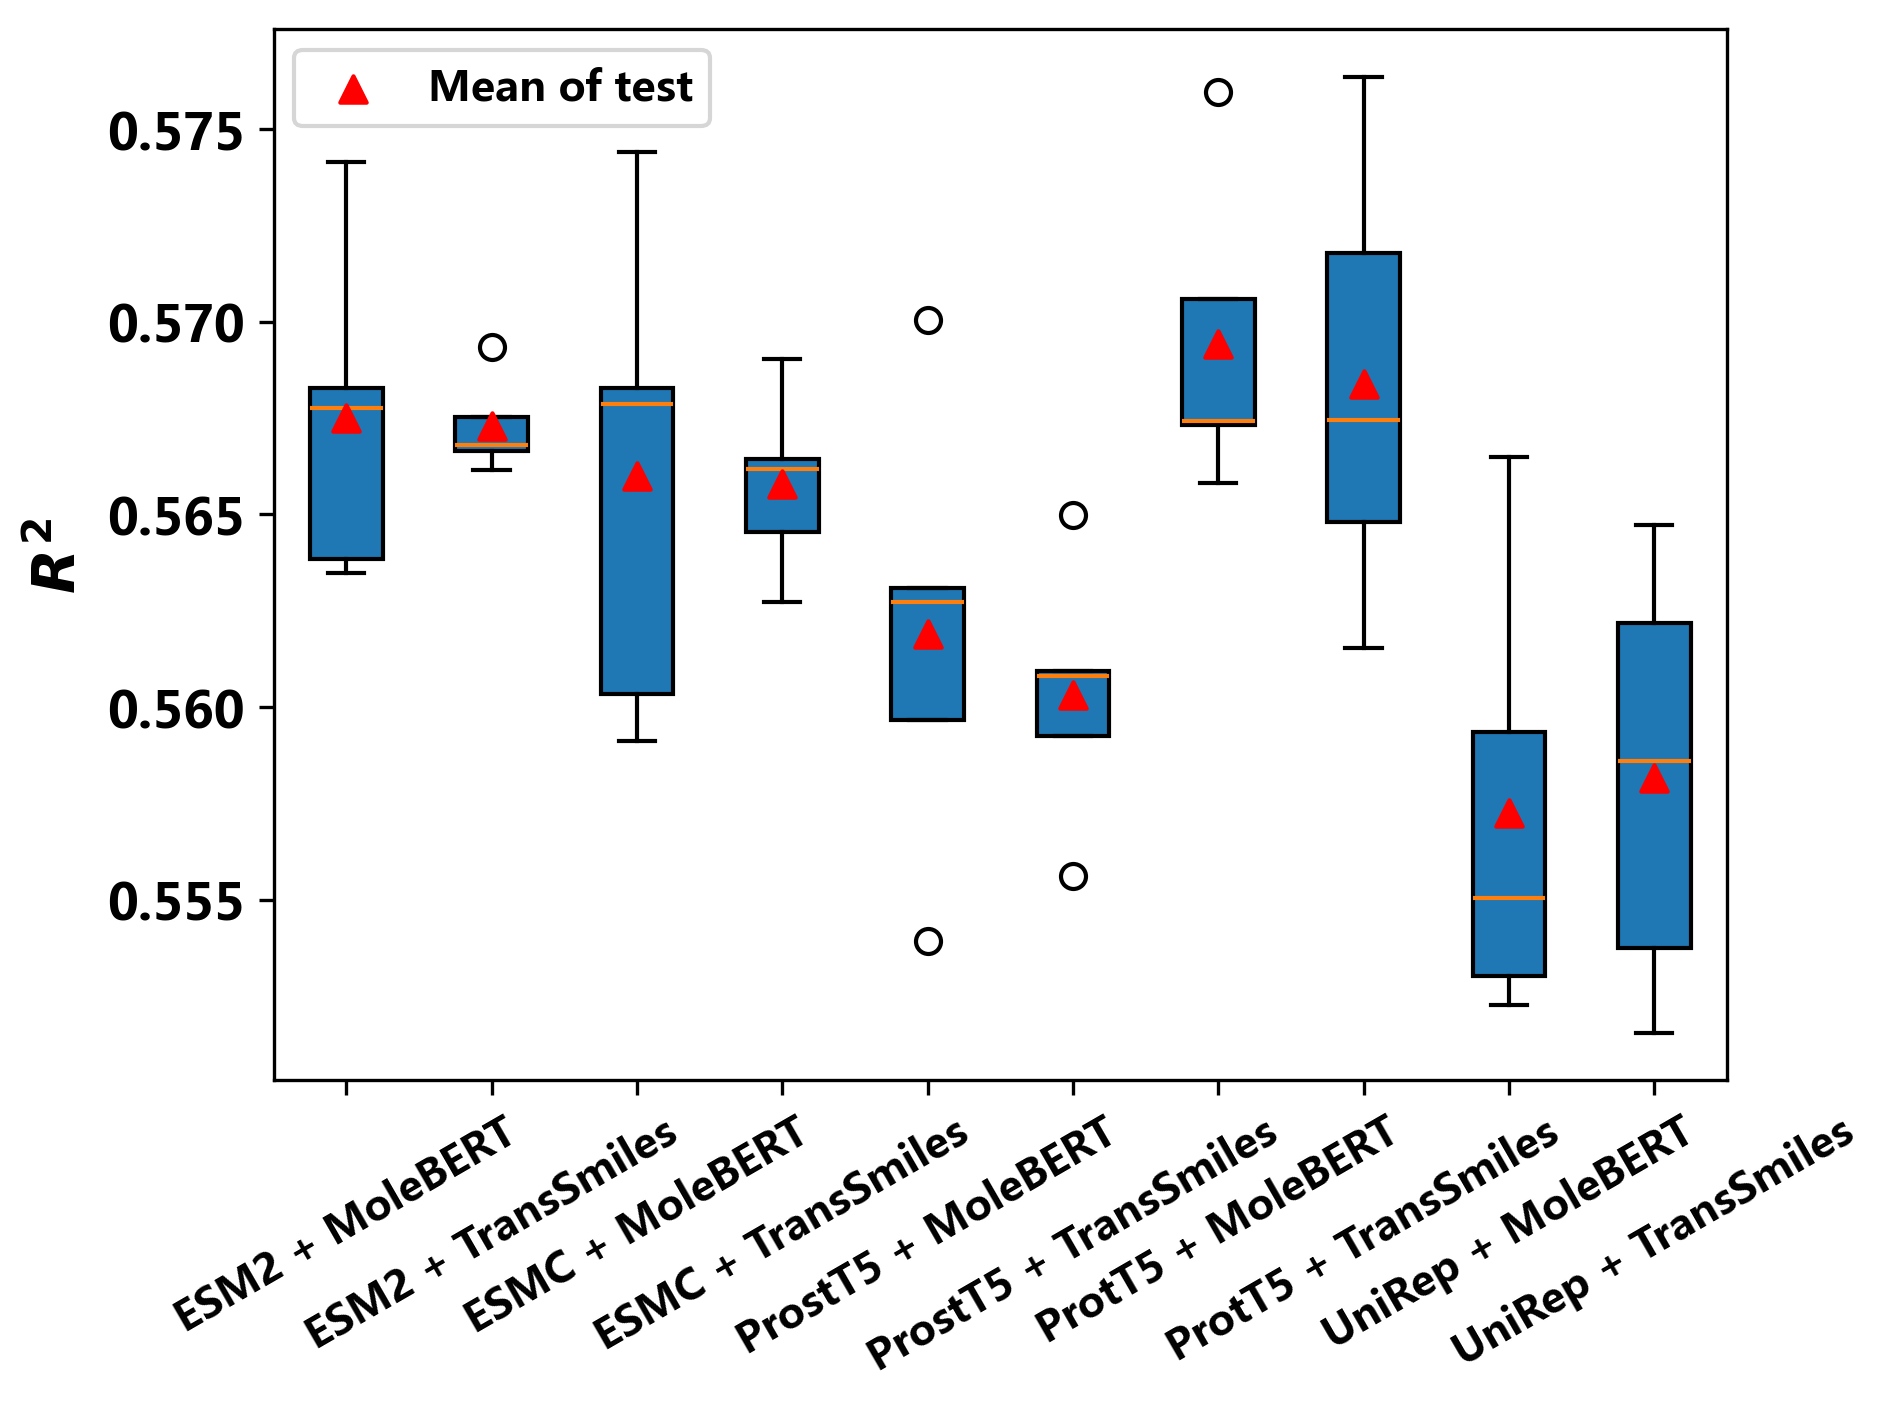

C:\Users\ching\AppData\Local\Temp\ipykernel_19788\666786242.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(rmse_values, labels=combination_names, patch_artist=True)


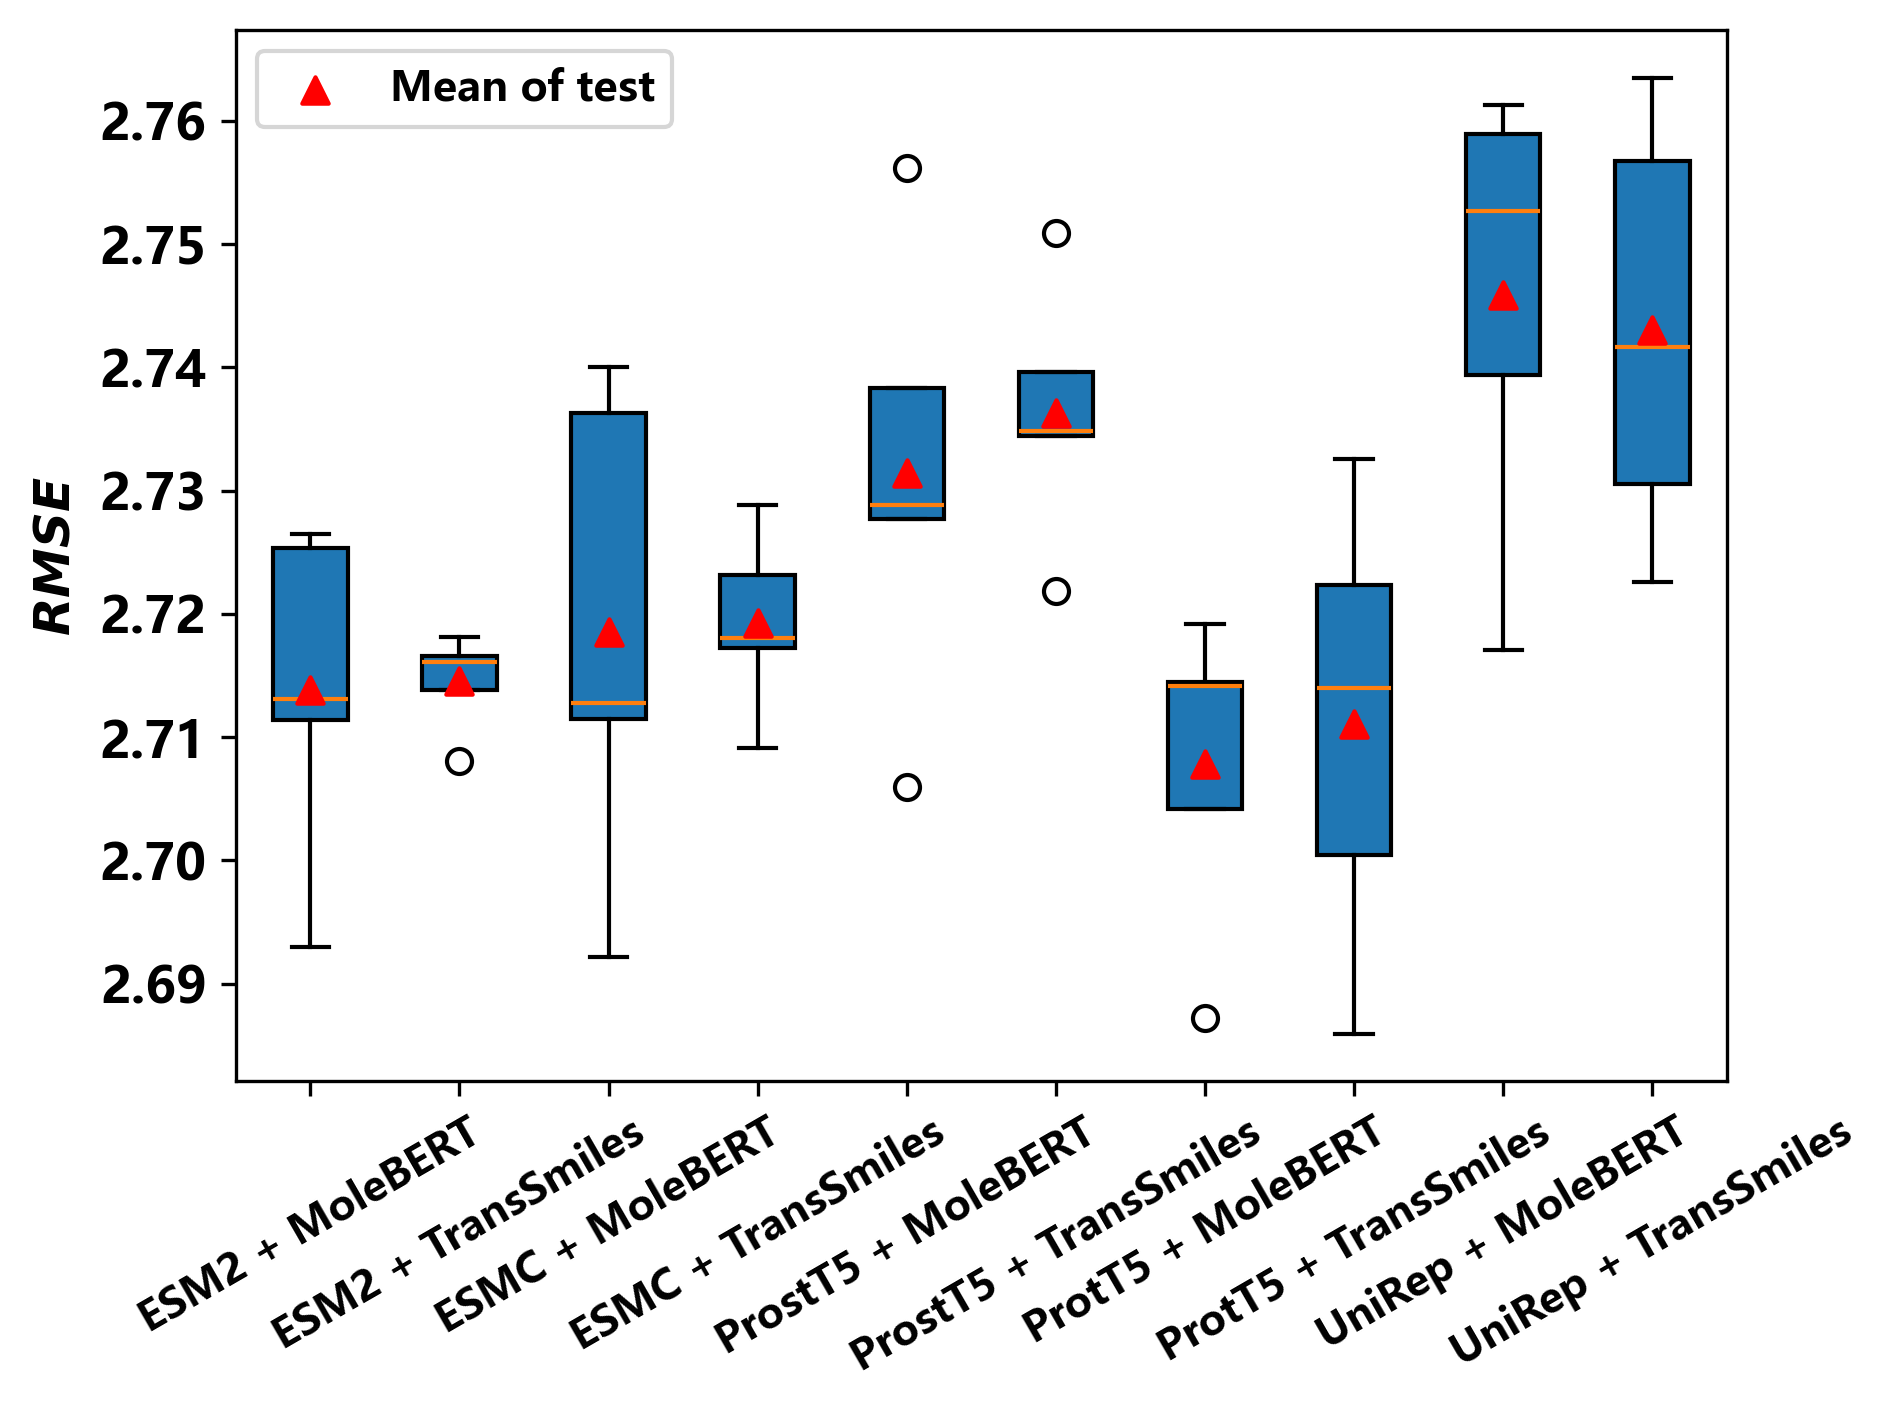

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'
import matplotlib
matplotlib.rc("font",family='MicroSoft YaHei',weight="bold")
import os
current_dir = os.getcwd()

df_cv_results = pd.read_excel(f"{current_dir}/cv_results.xlsx")
df_cv_results["Combination"] = df_cv_results["Protein"] + " + " + df_cv_results["Substrate"]
grouped = df_cv_results.groupby("Combination")
combination_names = list(grouped.groups.keys())
combination_names = [name.replace("unirep", "UniRep").replace("molebert", "MoleBERT").replace("transsmiles", "TransSmiles").replace("esmc", "ESMC").replace("prott5", "ProtT5").replace("prost5", "ProstT5").replace("esm2", "ESM2") for name in combination_names]

r2_values = [group["Test_R2"].values for _, group in grouped]
rmse_values = [group["Test_RMSE"].values for _, group in grouped]

test_r2_values_mean = [np.mean(vals) for vals in r2_values]
test_rmse_values_mean = [np.mean(vals) for vals in rmse_values]

# R2
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
plt.boxplot(r2_values, labels=combination_names, patch_artist=True)
# plt.scatter(r2_values, combination_names, c="red")
plt.scatter(range(1, len(combination_names) + 1), test_r2_values_mean,
                c='red', marker='^', s=40, linewidths=1, zorder=3, label="Mean of test")
plt.ylabel("$R^2$", fontsize=14)
plt.tick_params(axis="x", rotation=30, labelsize=10)
plt.tick_params(axis="y", labelsize=12)
plt.tight_layout()
plt.grid(False)
plt.legend(loc="best")
plt.savefig(f"{current_dir}/embedding_ablation_test_r2.png", dpi=300)
plt.show()

# RMSE
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
plt.boxplot(rmse_values, labels=combination_names, patch_artist=True)
plt.scatter(range(1, len(combination_names) + 1), test_rmse_values_mean,
                c='red', marker='^', s=40, linewidths=1, zorder=3, label="Mean of test")
plt.ylabel("$RMSE$", fontsize=12)
plt.tick_params(axis="x", rotation=30, labelsize=10)
plt.tick_params(axis="y", labelsize=12)
plt.tight_layout()
plt.grid(False)
plt.legend(loc="best")
plt.savefig(f"{current_dir}/embedding_ablation_test_rmse.png", dpi=300)
plt.show()